In [90]:
# 라이브러리 및 모듈 임포트
import torch
from torchvision import datasets, models, transforms
import urllib.request
import ast
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch.nn.functional as F

In [91]:
# 본인이 테스트하고자 하는 이미지(좌측 파일 클릭 후 업로드)
img_path = 'crab.jpg'

# ImageNet의 class 정보 불러오기
classes_url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
with urllib.request.urlopen(classes_url) as handler:
    data = handler.read().decode()
    classes = ast.literal_eval(data)

In [92]:
# ResNet 모델 및 이미지 전처리 설정
model_ft = models.resnet18(pretrained=True)
model_ft.eval()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize])


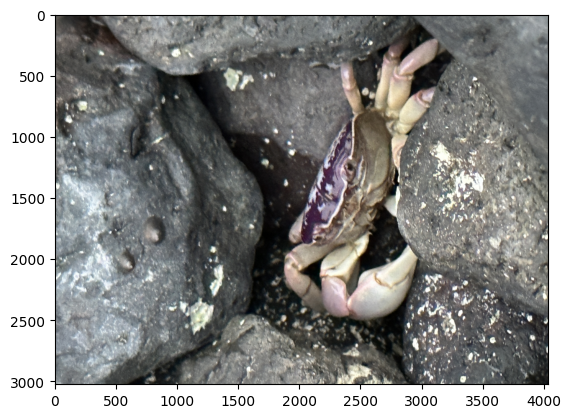

In [93]:
# 그림을 불러오기
raw_img = Image.open(img_path)
plt.imshow(raw_img)

plt.show()

In [94]:
# 이미지 전처리 및 모델 추론
img_input = preprocess(raw_img)
output = model_ft(img_input.unsqueeze(0))
softmaxValue = F.softmax(output)
class_id=int(softmaxValue.argmax().numpy())

print("결과 : {}".format(classes[class_id]))

결과 : rock crab, Cancer irroratus


<ipython-input-94-7594ce34b03e>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmaxValue = F.softmax(output)


In [95]:
# ResNet 구조 및 활성화 맵 관련 함수 정의
def get_activation_info(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    return x

# Feature Map 및 Weights 추출
feature_maps = get_activation_info(model_ft, img_input.unsqueeze(0)).squeeze().detach().numpy()
activation_weights = list(model_ft.parameters())[-2].data.numpy()
print("Feature MAP : {}".format(feature_maps.shape), "Weights : {}".format(activation_weights.shape))

Feature MAP : (512, 7, 7) Weights : (1000, 512)


In [96]:
# numpy로 이미지 변경
numpy_img = np.asarray(raw_img)

# CAM, HeatMap 생성 및 시각화 함수 정의
## CAM
def show_CAM(numpy_img, feature_maps, activation_weights, classes, class_id):
    cam_img = np.matmul(activation_weights[class_id], feature_maps.reshape(feature_maps.shape[0], -1)).reshape(feature_maps.shape[1:])
    cam_img = cam_img - np.min(cam_img)
    cam_img = cam_img/np.max(cam_img)
    cam_img = np.uint8(255 * cam_img)
## Heat Map
    heatmap = cv2.applyColorMap(cv2.resize(255-cam_img, (numpy_img.shape[1], numpy_img.shape[0])), cv2.COLORMAP_JET)
    result = numpy_img * 0.5 + heatmap * 0.3
    result = np.uint8(result)
    fig=plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(numpy_img)
## CAM 이미지
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(result)
    plt.suptitle("[{}] CAM Image".format(classes[class_id]), fontsize=30)
    plt.show()

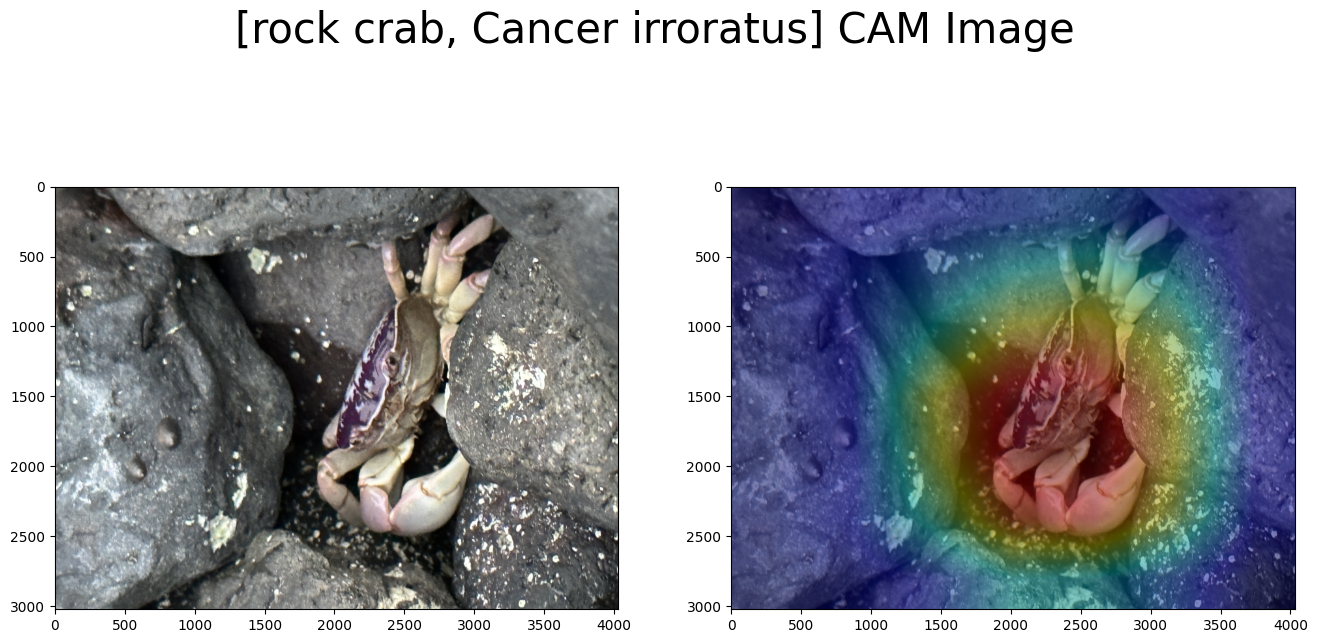

In [97]:
    show_CAM(numpy_img, feature_maps, activation_weights, classes, class_id)